In [1]:
import numpy as np

def homogenize(wavelength1, intensity1, wavelength2, intensity2):
    """Homogenize two spectra to have the same wavelength axis.
    
    """
    assert np.unique(np.diff(wavelength1)).size == 1, "Wavelength1 must be uniformly spaced"
    assert np.unique(np.diff(wavelength2)).size == 1, "Wavelength2 must be uniformly spaced"
    min_wavelength = min(wavelength1.min(), wavelength2.min())
    max_wavelength = max(wavelength1.max(), wavelength2.max())
    left1 = int(wavelength1[0] - min_wavelength)
    right1 = max_wavelength - wavelength1[-1]
    wavelength1_new = np.arange(min_wavelength, min_wavelength+ left1, 1).tolist() + wavelength1.tolist() + np.arange(wavelength1[-1]+1, max_wavelength+1, 1.).tolist()
    wavelength1_new = np.array(wavelength1_new)
    intensity1_new = np.zeros_like(wavelength1_new)
    intensity1_new[left1:left1+len(intensity1)] = intensity1

    left2 = int(wavelength2[0] - min_wavelength)
    right2 = max_wavelength - wavelength2[-1]
    wavelength2_new = np.arange(min_wavelength, min_wavelength+ left2, 1).tolist() + wavelength2.tolist() + np.arange(wavelength2[-1]+1, max_wavelength+1, 1.).tolist()
    wavelength2_new = np.array(wavelength2_new)
    intensity2_new = np.zeros_like(wavelength2_new)
    intensity2_new[left2:left2+len(intensity2)] = intensity2

    return wavelength1_new, intensity1_new, intensity2_new

In [2]:
from microsim import schema as ms
EGFP = ms.Fluorophore.from_fpbase("EGFP")
EGFP.emission_spectrum.intensity
EGFP.emission_spectrum.wavelength
filterd = ms.Bandpass.from_fpbase('semrock-ff01-441-511-593-684-817')
fitc = ms.Fluorophore.from_fpbase("Fluorescein-fitc")
dapi = ms.Fluorophore.from_fpbase("DAPI")
tritc = ms.Fluorophore.from_fpbase("tetramethylrhodamine-tamra-tritc")

In [3]:
i1 = fitc.emission_spectrum.intensity
i1 = i1 / i1.sum()
lambda1 = fitc.emission_spectrum.wavelength
name1 = 'FITC'

i2 = dapi.emission_spectrum.intensity
i2 = i2 / i2.sum()
lambda2 = dapi.emission_spectrum.wavelength
name2 = 'DAPI'

w, i1, i2 = homogenize(lambda1,
                       i1,
                       lambda2,
                       i2)

i3 = tritc.emission_spectrum.intensity
i3 = i3 / i3.sum()
lambda3 = tritc.emission_spectrum.wavelength
name3 = 'TRITC'

w_final, i1, i3 = homogenize(w,
                       i1,
                       lambda3,
                       i3)

_, i2, i3 = homogenize(w,
                       i2,
                       w_final,
                       i3)

In [4]:
name1, name2

('FITC', 'DAPI')

In [5]:
def find_optimal_lambda_threshold(i1, i2):
    """
    Find the index such that the sum of intensities on the left side for i1 and right side for i2 is maximized.
    """
    max_sum = -1
    optimal_index = -1
    for idx in range(len(i1)):
        left_sum = i1[:idx].sum()
        right_sum = i2[idx:].sum()
        total_sum = left_sum + right_sum
        if total_sum > max_sum:
            max_sum = total_sum
            optimal_index = idx
    return optimal_index, max_sum

In [14]:
idx1, sum1 = find_optimal_lambda_threshold(i1, i2)
idx2, sum2 = find_optimal_lambda_threshold(i2, i1)

if sum1 > sum2:
    left = i1 
    right = i2
    threshold_left_idx = idx1
    names = (name1, name2)
else:
    left = i2
    right = i1
    threshold_left_idx = idx2
    names = (name2, name1)

In [15]:
import matplotlib.pyplot as plt
# _,ax = plt.subplots(figsize=(4,4))
# ax.plot(w_final[:threshold_idx], left[:threshold_idx], label=names[0], c ='blue')
# ax.plot(w_final[threshold_idx:], left[threshold_idx:], c ='blue', linestyle='--')
# ax.plot(w_final[threshold_idx:], right[threshold_idx:], label=names[1], c ='orange')
# ax.plot(w_final[:threshold_idx], right[:threshold_idx], c ='orange', linestyle='--')
# ax.axvline(w_final[threshold_idx], color='k', linestyle='--', label='Optimal Threshold')

# ax.legend(loc ='upper right', fontsize=8)
# ax.set_xlabel('Wavelength (nm)')

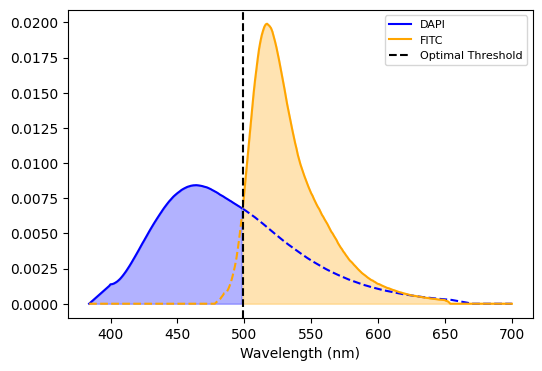

In [32]:
# ...existing code...
import matplotlib.pyplot as plt
_,ax = plt.subplots(figsize=(6,4))
ax.plot(w_final[:threshold_left_idx], left[:threshold_left_idx], label=names[0], c='blue')
ax.plot(w_final[threshold_left_idx:], left[threshold_left_idx:], c='blue', linestyle='--')
ax.plot(w_final[threshold_left_idx:], right[threshold_left_idx:], label=names[1], c='orange')
ax.plot(w_final[:threshold_left_idx], right[:threshold_left_idx], c='orange', linestyle='--')
ax.axvline(w_final[threshold_left_idx], color='k', linestyle='--', label='Optimal Threshold')

# fill under the solid (non-dashed) parts with matching colors
ax.fill_between(w_final[:threshold_left_idx], left[:threshold_left_idx], color='blue', alpha=0.3, zorder=0)
ax.fill_between(w_final[threshold_left_idx:], right[threshold_left_idx:], color='orange', alpha=0.3, zorder=0)

ax.legend(loc='upper right', fontsize=8)
ax.set_xlabel('Wavelength (nm)')
plt.savefig('photon_efficiency_comparison_2Channel.png', dpi=150)
# ax.set_xlabel('Wavelength (

In [29]:
left[:threshold_left_idx].sum() + right[threshold_left_idx:].sum()

1.5798110957783207

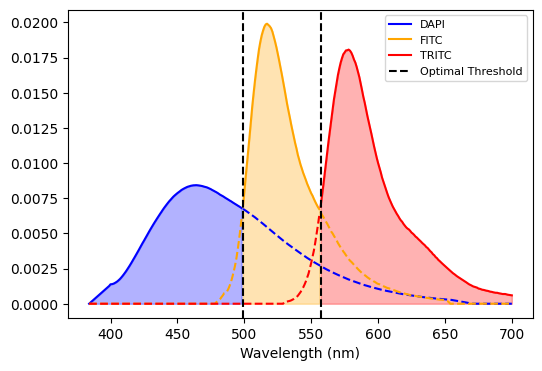

In [31]:
threshold_right_idx, _ = find_optimal_lambda_threshold(right, i3)
_,ax = plt.subplots(figsize=(6,4))
ax.plot(w_final[:threshold_left_idx], left[:threshold_left_idx], label=names[0], c='blue')
ax.plot(w_final[threshold_left_idx:], left[threshold_left_idx:], c='blue', linestyle='--')
ax.plot(w_final[threshold_left_idx:threshold_right_idx], right[threshold_left_idx:threshold_right_idx], label=names[1], c='orange')
ax.plot(w_final[:threshold_left_idx], right[:threshold_left_idx], c='orange', linestyle='--')
ax.plot(w_final[threshold_right_idx:], right[threshold_right_idx:], c='orange', linestyle='--')
ax.plot(w_final[threshold_right_idx:], i3[threshold_right_idx:], c='red', label=name3)
ax.plot(w_final[:threshold_right_idx], i3[:threshold_right_idx], c='red', linestyle='--')

ax.axvline(w_final[threshold_left_idx], color='k', linestyle='--', label='Optimal Threshold')
ax.axvline(w_final[threshold_right_idx], color='k', linestyle='--')

# fill under the solid (non-dashed) parts with matching colors
ax.fill_between(w_final[:threshold_left_idx], left[:threshold_left_idx], color='blue', alpha=0.3, zorder=0)
ax.fill_between(w_final[threshold_left_idx:threshold_right_idx], right[threshold_left_idx:threshold_right_idx], color='orange', alpha=0.3, zorder=0)
ax.fill_between(w_final[threshold_right_idx:], i3[threshold_right_idx:], color='red', alpha=0.3, zorder=0)

ax.legend(loc='upper right', fontsize=8)
ax.set_xlabel('Wavelength (nm)')
# save  with ddpi=150
plt.savefig('photon_efficiency_comparison_3Channel.png', dpi=150)

In [28]:
left[:threshold_left_idx].sum() + right[threshold_left_idx:threshold_right_idx].sum() + i3[threshold_right_idx:].sum()

2.346181124000177

In [33]:
3/2.34 * 100

128.2051282051282